In [1]:
import cv2
import numpy as np
import bottleneck as bn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
def remove_stamps(image, max_size=1e7):
    """ Remove colourful stamps (single color) from RGB image
    3D-ndarray image: RGB image
    int max_size: Max pixcels limit of the image
    """
    # Reduce size if origin image exceed max_size
    if image.size > max_size*3:
        ratio = (max_size*3 / image.size)**0.5
        image = cv2.resize(image, dsize=(0, 0), fx=ratio, fy=ratio)

    # Smaller img to improve pca speed
    ratio = (1e6 / image.size)**0.5
    resized = cv2.resize(image, dsize=(0, 0), fx=ratio, fy=ratio)
    X = resized.reshape(-1, 3)

    # Find PCA Matrix to find color outliers
    pca = PCA(n_components=2)  # Support single color stamps
    pca.fit(X)
    
    
    # Transform origin image by PCA
    Y = pca.transform(image.reshape(-1, 3))
    Y = Y.T

    #####################################
    # Replace Stamps Pixcels (Fast Version)
    #####################################
    bmax = bn.nanmax(Y[0])
    bmin = bn.nanmin(Y[0])
    # Only on those has red stamps
    condition_1 = pca.explained_variance_ratio_[0]<1-3e-3 # Has color stamp ?
    condition_2 = pca.components_[0,-1]*pca.components_[1,-1]<0 # color is red ?
#     print(condition_1,condition_2)
    
    if condition_1 or condition_2:
        black_std = bn.nanstd(Y[0])
        white_tmp = -black_std * 0.5

        mask_outlier = (Y[1] > bn.nanstd(Y[1]) * 2)
        mask_black = (Y[0] > bmax * 0.6)
        mask_white = (Y[0] < black_std * 0.5)

        # Enhance Black Words
        mask = np.logical_and(mask_outlier, mask_black)
        black = (Y[0][mask] + bmax) * 0.5
        np.place(Y[0], mask, black)

        # Blur and Enhance White background
        white = Y[0].copy()
        mask = np.logical_or(mask_outlier, mask_black)
        np.copyto(white, white_tmp, where=mask)
        white = white.reshape(image.shape[:2])
        white = cv2.resize(white, dsize=resized.shape[:2][::-1])
        white = cv2.GaussianBlur(white, (21, 21), 0)
        white = cv2.resize(white, dsize=image.shape[:2][::-1]).reshape(-1)
        mask = np.logical_or(np.logical_and(mask_outlier, ~mask_black), mask_white)
        np.copyto(Y[0], white, where=mask)
    #######################################

    # Return gray image without stamps

    return np.interp(Y[0], [bmin, bmax],
                     [255, 0]).astype(int).reshape(image.shape[:2])

image = cv2.imread('../test_img/8.JPG')
# image = cv2.imread('../img_new/hard/2.JPG')
cv2.imwrite('original.jpg', image)
rm_stamps = remove_stamps(image)
cv2.imwrite('no_stamp.jpg', rm_stamps)

In [4]:
image = cv2.imread('../test_img/3.JPG')
# image = cv2.imread('../img_new/hard/2.JPG')
print(image.shape)
cv2.imwrite('original.jpg', image)

# plt.figure(figsize = (15,15))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

(4032, 3024, 3)


True

(667, 500, 3)
(333500, 3)


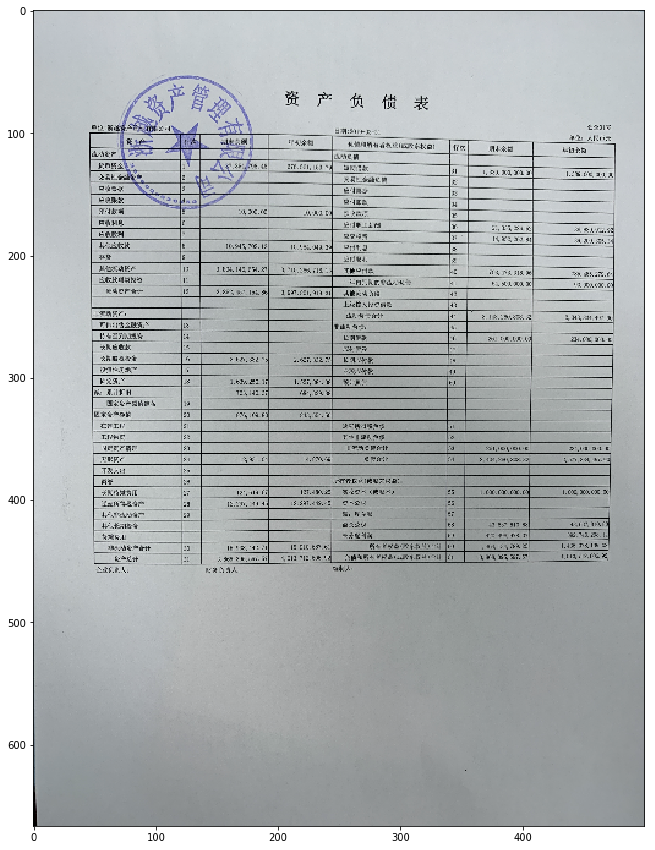

In [5]:
# Use PCA to find color outliers

## smaller img to improve pca speed
ratio = (1e6 / image.size)**0.5
resized = cv2.resize(image, dsize=(0, 0), fx=ratio, fy=ratio)
print(resized.shape)
plt.figure(figsize = (15,15))
plt.imshow(resized)
X = resized.reshape(-1,3)
print(X.shape)


In [6]:
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.99637041 0.00340464]


-0.34754464780308986 67.5948126497554


(array([3.970000e+02, 1.159500e+04, 1.582210e+05, 2.723725e+06,
        2.050954e+06, 1.458772e+06, 1.446495e+06, 2.734587e+06,
        7.643210e+05, 7.889200e+04, 6.674600e+04, 5.446200e+04,
        4.964800e+04, 5.246600e+04, 5.920000e+04, 6.513500e+04,
        6.667100e+04, 7.272900e+04, 7.452500e+04, 2.032270e+05]),
 array([-135.72126699, -114.21295194,  -92.70463689,  -71.19632185,
         -49.6880068 ,  -28.17969175,   -6.6713767 ,   14.83693834,
          36.34525339,   57.85356844,   79.36188349,  100.87019854,
         122.37851358,  143.88682863,  165.39514368,  186.90345873,
         208.41177377,  229.92008882,  251.42840387,  272.93671892,
         294.44503397]),
 <a list of 20 Patch objects>)

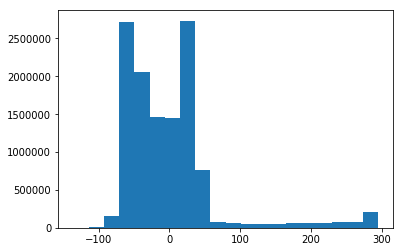

In [7]:
Y = pca.transform(image.reshape(-1,3))
Y.shape
y=Y.T[0]
print(np.mean(y),np.std(y))
plt.hist(y,bins=20)

In [8]:
Y = pca.transform(image.reshape(-1, 3))
Y = Y.T

#####################################################
# Version 1

# t1 = bn.nanmax(Y[0]) * 0.6  # threshold of black
# t2 = bn.nanstd(Y[0]) * 0.5  # threshold of white
# t3 = bn.nanstd(Y[1]) * 2  # threshold of color outlier
# t4 = -bn.nanstd(Y[0]) * 0.5  # temporary backgroud color
# t5 = bn.nanmax(Y[0])  # max black color

# black = (t5 + Y[0]) * 0.5

# white = np.where(np.logical_or(Y[1] > t3, Y[0] > t1), t4, Y[0])  # remove black
# white = white.reshape(image.shape[:2])
# white = cv2.resize(white, dsize=resized.shape[:2][::-1])
# white = cv2.GaussianBlur(white, (21, 21), 0)
# white = cv2.resize(white, dsize=image.shape[:2][::-1]).reshape(-1)

# Y[0] = np.where(np.logical_and(Y[1] > t3, Y[0] >= t1), black, Y[0])
# Y[0] = np.where(np.logical_and(Y[1] > t3, Y[0] < t1), white, Y[0])
# Y[0] = np.where(Y[0] < t2, white, Y[0])


#####################################################
# Version 2

black_max = bn.nanmax(Y[0])
black_std = bn.nanstd(Y[0])
white_tmp = -black_std * 0.5

mask_outlier = (Y[1] >  bn.nanstd(Y[1]) * 2)
mask_black = (Y[0] > black_max * 0.6)
mask_white = (Y[0] < black_std * 0.5)

# Enhance Black Words
mask = np.logical_and(mask_outlier, mask_black)
black = (Y[0][mask] + black_max) * 0.5
np.place(Y[0], mask, black)

# Blur and Enhance White background
white = Y[0].copy()
mask = np.logical_or(mask_outlier, mask_black)
np.copyto(white, white_tmp, where=mask)
white = white.reshape(image.shape[:2])
white = cv2.resize(white, dsize=resized.shape[:2][::-1])
white = cv2.GaussianBlur(white, (21, 21), 0)
white = cv2.resize(white, dsize=image.shape[:2][::-1]).reshape(-1)
mask = np.logical_or(np.logical_and(mask_outlier, ~mask_black), mask_white)
np.copyto(Y[0], white, where=mask)

##########################################################

Y[1] = 0
Y = Y.T

(12192768, 3)


True

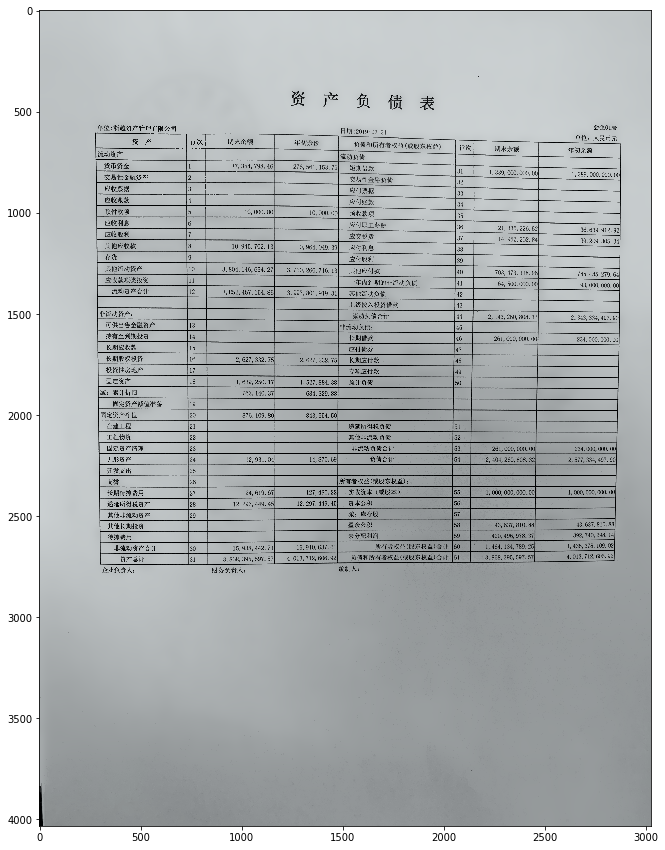

In [9]:
XX = pca.inverse_transform(Y)
print(XX.shape)
restored = XX.reshape(image.shape).astype(int)
restored[restored<0]=0

plt.figure(figsize = (15,15))
plt.imshow(restored)
cv2.imwrite('rm_stamps.jpg', restored)



XX = Y.T[0]
XX = 1-(XX-bn.nanmin(XX))/(bn.nanmax(XX)-bn.nanmin(XX))
XX= XX.reshape(image.shape[:2])*255
XX = XX.astype(int)
cv2.imwrite('rm_stamps_grey.jpg', XX)

# Benchmarks of MA method
- numpy
- scipy
- talib
- bottleneck

In [10]:
from scipy.ndimage.filters import uniform_filter1d
import talib as ta
import bottleneck as bn

z1 = Y.T[0]

In [11]:
for i in range(10):
    # a = np.convolve(z1, np.ones((50,))/50, mode='same')
    a = np.max(z1)
# p = a
# print(p.shape,p[:5],p[50:55])

In [12]:
b = uniform_filter1d(z1, size=50)
p = b
print(p.shape,p[:5],p[50:55])

(12192768,) [-46.69751077 -46.6973851  -46.69700807 -46.69642549 -46.69575284] [-47.11651149 -47.14598604 -47.17631024 -47.2074297  -47.23922895]


In [13]:
c = ta.MA(z1, 50)
p = c
print(p.shape,p[:5],p[50:55])

(12192768,) [nan nan nan nan nan] [-46.70699726 -46.71292025 -46.71969079 -46.72733947 -46.73590001]


In [14]:
for i in range(10):
    # d = bn.move_mean(z1,50)
    d = bn.nanmax(z1)
# p = d
# print(p.shape,p[:5],p[50:55])